In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob 
import re
import torch
from hydra.utils import instantiate
from hydra import initialize, compose
import omegaconf
from soundbay.inference import load_model
from soundbay.data import ClassifierDataset
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score
%matplotlib inline

/anaconda/envs/pywhale/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
model_path='../../soundbay/checkpoints/d0grath1/best.pth'
selection_tables_path = '/home/azureuser/danielle/notebooks/selection_tables/MARION_ISLAND_KW_SELECTION_TABLES'

# Load model and dataloader from config YAML

In [3]:
import os

In [5]:
os.chdir('../../soundbay/soundbay/')  # This is needed - compose works only from the source dir of the package

In [6]:
with initialize(config_path='../../soundbay/soundbay/conf/'):
        cfg = compose(config_name="runs/marion_killer_whale.yaml")
        cfg.data.val_dataset.metadata_path = 'annotations_all_call_types/val_0.75_by_files_multiclass_frame.csv'


/anaconda/envs/pywhale/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  """Entry point for launching an IPython kernel.


In [7]:
val_dataset=ClassifierDataset(**{k:v for k,v in cfg.data.val_dataset.items() if k not in ['_target_']})

## Load model state from checkpoint

In [10]:
model = instantiate(cfg.model.model)
ckpt_dict = torch.load(model_path, map_location=torch.device('cuda'))
device = torch.device('cuda')
model.load_state_dict(ckpt_dict['model'])
model = model.to(device)
model = model.eval()

## Create data loader from dataset

In [11]:
data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, num_workers=6, shuffle=False, pin_memory=True)

# Plot classification results

### function that returns arrays of labels and predictions 

In [12]:
def preds_and_labels(model, dataloader):
    y_true = []
    y_pred = []
    for batch in data_loader:
        pred = model(batch[0].to(device)).detach().cpu().numpy()
        label = batch[1].cpu().numpy()
        y_pred.append(pred)
        y_true.append(label)
    return np.concatenate(y_true, axis=0), np.concatenate(y_pred, axis=0)

In [13]:
y_true, y_pred = preds_and_labels(model, data_loader)

in /danielle_mnt/audio/audio_source/5756.220309093455.wav, one of the val's begin times is too big and exceeding the file so it was set to be smaller
begin time:80525714, last_start_time:80492848
in /danielle_mnt/audio/audio_source/5756.220422183455.wav, one of the val's begin times is too big and exceeding the file so it was set to be smaller
begin time:80509152, last_start_time:80496640


In [ ]:
th = 0.2

In [14]:
agg_y_true = pd.Series(y_true).between(1,5).astype(int)

In [15]:
agg_y_pred = (torch.nn.Softmax(dim=1)(torch.Tensor(y_pred)).numpy() > th)[:,1:6].any(axis=1).astype(int)

In [16]:
metadata = val_dataset.metadata.assign(
    y_true=agg_y_true, 
    y_pred=agg_y_pred, 
    label=y_true,
    sm=torch.nn.Softmax(dim=1)(torch.Tensor(y_pred)).numpy()[:, 1:6].max(axis=1),
    pred_label = lambda df: (torch.nn.Softmax(dim=1)(torch.Tensor(y_pred)).numpy().argmax(axis=1)) * (df.sm > 0.5).astype(int),
    prob=torch.nn.Softmax(dim=1)(torch.Tensor(y_pred)).numpy()[:, 1],
    year=lambda df: df.date.astype(str).str[:4], 
    month=lambda df: df.date.astype(str).str[4:6], 
    hour=lambda df: df.time.astype(str).str[:2], 
    Annotation=lambda df: df.y_pred == df.y_true
)

In [17]:
metadata.groupby('call_type', dropna=False).y_pred.count().sort_index()

call_type
Downsweeps      991
Squeaks         149
Tones           181
Upsweeps        431
Whistles         60
NaN           15271
Name: y_pred, dtype: int64

In [18]:
metadata.groupby('call_type', dropna=False).y_pred.mean().sort_index()

call_type
Downsweeps    0.919273
Squeaks       0.845638
Tones         0.535912
Upsweeps      0.923434
Whistles      0.966667
NaN           0.035296
Name: y_pred, dtype: float64

In [84]:
f1_score(metadata.y_true, metadata.y_pred, average='macro')

0.8908619843267183

### Plot confuion matrix for variety of classification thresholds

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay

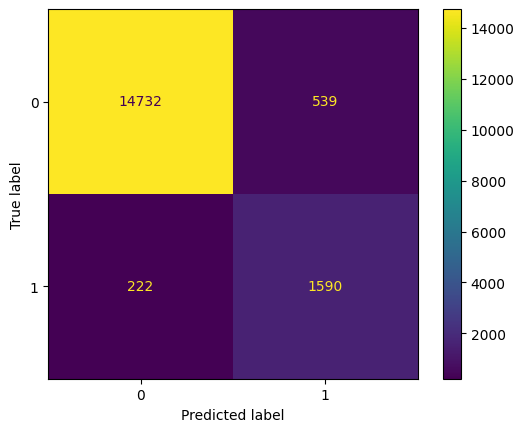

In [113]:
ConfusionMatrixDisplay.from_predictions(
    metadata.y_true, 
    metadata.y_pred,
    labels=[0, 1]
)

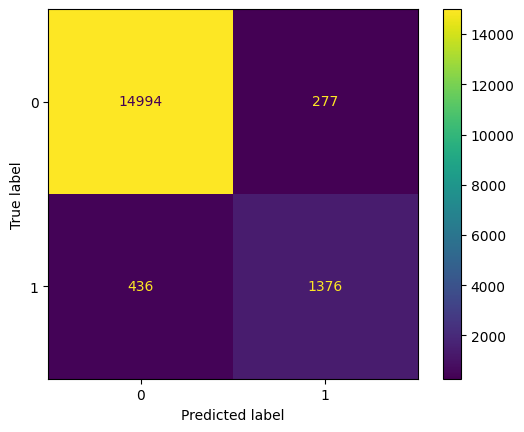

In [27]:
ConfusionMatrixDisplay.from_predictions(
    metadata.y_true, metadata.sm > 0.5,
    labels=[0, 1]
)

# Plot data, labels and predictions for couple of images in the first batch

In [34]:
data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, num_workers=6, shuffle=True, pin_memory=True)

In [35]:
batch = next(iter(data_loader))

In [36]:
pred = model(batch[0].to(device)).argmax(axis=1).cpu().numpy()

In [37]:
import librosa.display
def show_spectrogram(audio_processed, title, n_fft=512, hop_length=128):
    fig, ax = plt.subplots()
    img=librosa.display.specshow(
        audio_processed, 
        hop_length=hop_length, 
        n_fft=n_fft, 
        x_axis='time', 
        y_axis='mel'
    )
    fig.colorbar(img, ax=ax, format="%+2.2f dB")
    plt.title(f"{str(title)}")

    plt.show()

In [1]:
for i in range(min(len(batch[1]), 32)):
    plt.figure(figsize=(15,5))
    show_spectrogram(batch[0][i][0].numpy(), title=f'Label {batch[1][i].numpy()} prediction {pred[i]}')
    plt.show()